<a href="https://colab.research.google.com/github/anshdeepsinghrajput/Recommendation-system/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics , model_selection, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device

In [ ]:
df = pd.read_csv('ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# **Training Dataset Class Wrapper**

In [ ]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    # len(movie_dataset)
    def __len__(self):
        return len(self.users)

    # movie_dataset[1]
    def __getitem__(self, item):
        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users" : torch.tensor(users, dtype = torch.long),
            'movies' : torch.tensor(movies, dtype = torch.long),
            'ratings' : torch.tensor(ratings, dtype = torch.long)
        }

# **Create the model**

In [ ]:
class RecommendationModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()

        # trainable lookup matrix for shallow embedding vectors
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)

        # user movie embedding concat
        self.out = nn.Linear(64, 1)

    def forward(self, users, movies, ratings = None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds,movie_embeds], dim = 1)

        output = self.out(output)

        return output

In [ ]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=42, stratify=df.rating.values)

train_dataset = MovieDataset(
        users = df_train.userId.values,
        movies = df_train.movieId.values,
        ratings = df_train.rating.values)

valid_dataset = MovieDataset(
        users = df_valid.userId.values,
        movies = df_valid.movieId.values,
        ratings = df_valid.rating.values)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
validation_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
model = RecommendationModel(
        n_users = len(lbl_user.classes_),
        n_movies = len(lbl_movie.classes_),
)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma = 0.7)

loss_func = nn.MSELoss()

In [ ]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
90752


In [ ]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data['users'], train_data["movies"])

        # view(4, -1) to reshape the rating to match the shape of model output
        rating = train_data['ratings'].view(4,-1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data['users'])

        if (step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data['users']) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total loss

epoch 0 loss at step: 5000 is 0.4332079911716282
epoch 0 loss at step: 10000 is 0.16590388791924343
epoch 0 loss at step: 15000 is 0.10733553168550133
epoch 0 loss at step: 20000 is 0.08070742640187964
epoch 0 loss at step: 25000 is 0.07063196193352342
epoch 0 loss at step: 30000 is 0.06596689902851358
epoch 0 loss at step: 35000 is 0.06482643673410639
epoch 0 loss at step: 40000 is 0.06306144882403314
epoch 0 loss at step: 45000 is 0.061438954237126746
epoch 0 loss at step: 50000 is 0.059014785214420405
epoch 0 loss at step: 55000 is 0.05803099979897961
epoch 0 loss at step: 60000 is 0.05962407665569335
epoch 0 loss at step: 65000 is 0.06082634996687993
epoch 0 loss at step: 70000 is 0.055451769298780706
epoch 0 loss at step: 75000 is 0.0590545153404586
epoch 0 loss at step: 80000 is 0.05833494967399165
epoch 0 loss at step: 85000 is 0.05758131215823814
epoch 0 loss at step: 90000 is 0.05589889083635062


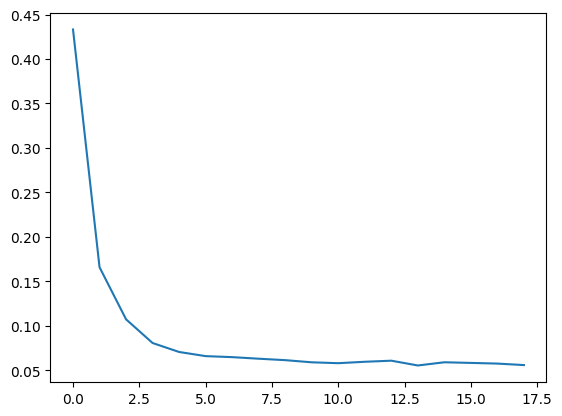

In [ ]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

# **Evaluation with RMSE**

In [ ]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        model_output = model(batched_data['users'], batched_data["movies"])
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data['ratings']
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']) )

        print(f'model_output: {model_output}, target_rating: {target_rating}')

rmse = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f'RMSE: {rmse}')

In [ ]:
from collections import defaultdict

# dict that store a list of predicted rating and actual rating pair of each other
user_est_true = defaultdict(list)

# iterate through the validation data to build the user -> [(y1,y1_hat), (y2, y2_hat)...]
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        users = batched_data['users']
        movies = batched_data["movies"]
        ratings = batched_data['ratings']

        model_output = model(batched_data['users'], batched_data["movies"])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))

In [ ]:
with torch.no_grad():
    precision = dict()
    recall = dict()

    k = 100
    threshold = 3.5

    for uid, user_ratings in user_est_true.items():

      # sort user ratings by estimated value
      user_ratings.sort(key=lambda x: x[0], reverse=True)

      # get the number of actual relevant item
      n_rel = sum((true_r > threshold) for (_, true_r) in user_ratings)

      # get the number of recommend item that are predicted relevant and within topk
      n_rec_k = sum((est > threshold) for (est, _) in user_ratings[:k])

      #  get the number of recommend item that is also actually relevalnt within topk
      n_rel_and_rec_k = sum(((true_r > threshold) and (est > threshold))
                            for (est, true_r) in user_ratings[:k])

      print(f" uid {uid}, n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

      # calculate precision and recall
      precision[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
      recall[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

In [ ]:
# precisioinn and recall can be averaged over all the users
print(f"Precision @ {100}: {sum(prec for prec in precision.values()) / len(precision)}")
print(f"Recall @ {100}: {sum(rec for rec in recall.values()) / len(recall)}")

Precision @ 100: 0.5500199994363533
Recall @ 100: 0.5405403584878641
